# Install important library

In [1]:
pip install rouge-score sacrebleu evaluate torchsummary

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c11e544e8fc4dfbe658925f23fce82223c9307ed49663e5df0302b82619af4dd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


# Import Library

In [2]:
import torch
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

from datasets import Dataset
from sklearn.model_selection import train_test_split

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torchsummary import summary

from collections import defaultdict
warnings.filterwarnings("ignore")

# Cleaning Data

In [3]:
#Load Data
df = pd.read_csv('/kaggle/input/layoutlm/medquad.csv')

# Sampel Data
print("Data Sample")
print(df.head())

#Null value
print("Null Value Data")
print(df.isnull().sum())

# List of question words
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Ensure questions are lowercase for consistent filtering
df['question'] = df['question'].str.lower()

# Filter rows where the question starts with a question word
df = df[df['question'].str.split().str[0].isin(question_words)]

df = df.reset_index(drop=True)

# Check for duplicate rows
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
df = df.drop_duplicates()

# Reset the index after removing duplicates
df.reset_index(drop=True, inplace=True)

#Delete Unused column
df = df.drop(columns=['source', 'focus_area'])

#Table Info
print("Table Info")
print(df.info())

# Apply the function
df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

#Drop rows with null values
df = df.drop_duplicates(subset=['question', 'answer']).reset_index(drop=True)
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

# Removing "(are)" in the dataset
def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)
    text = re.sub(r'\s+', ' ', text.strip().lower())
    return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

#Checking again of null values
print("Null Value Data")
print(df.isnull().sum())

#Check for Unique Data
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")

#Checking again of the data info
df.info()
df.head()

Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Number of duplicate rows: 48
Table Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1

,question,answer
0,what is glaucoma ?,glaucoma is a group of diseases that can damag...
1,what causes glaucoma ?,"nearly 2.7 million people have glaucoma, a lea..."
2,what are the symptoms of glaucoma ?,symptoms of glaucoma glaucoma can develop in o...
3,what are the treatments for glaucoma ?,"although open-angle glaucoma cannot be cured, ..."
4,who is at risk for glaucoma? ?,anyone can develop glaucoma. some people are a...


# Architecting Model

In [4]:
# Load T5-small model and tokenizer
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)
config.dropout_rate = 0.1
config.feed_forward_proj = "gelu"  
model = T5ForConditionalGeneration.from_pretrained(
    model_name, 
    config=config
)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Tie weights explicitly
model.resize_token_embeddings(len(tokenizer))

# Print model architecture summary
# Print detailed model summary
print("\nDetailed Model Summary:")
print("=" * 50)

def summarize_model_by_type(model):
    layer_summary = defaultdict(int)
    param_summary = defaultdict(int)

    for name, module in model.named_modules():
        layer_type = type(module).__name__
        layer_summary[layer_type] += 1
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())

    print(f"{'Layer Type':<30}{'Count':<10}{'Parameters':<15}")
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)

# Preprocess function for seq2seq task
def preprocess_function(batch):
    inputs = [f"answer the following question: {q}" for q in batch['question']]
    targets = [f"{a}" for a in batch['answer']]
    
    model_inputs = tokenizer(
        inputs,
        max_length=128,  
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=64,  
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
    
    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
# print('Halo: ',val_dataset.column_names)

# Preprocess datasets
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  
    remove_columns=train_dataset.column_names,
    num_proc=4,   
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  
    remove_columns=val_dataset.column_names,
    num_proc=4,  
)


# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    # eval_steps=1000,  
    # save_steps=1000,  
    save_total_limit=2,  
    learning_rate=5e-4,   
    num_train_epochs=10,   
    per_device_train_batch_size=8,   
    per_device_eval_batch_size=8, 
    lr_scheduler_type="cosine_with_restarts",  
    warmup_ratio=0.1,  
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=True,   
    logging_dir="./logs",
    logging_steps=50,  
    # load_best_model_at_end=True,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=2,   
    max_grad_norm=0.5,
    optim="adamw_torch_fused",  
    generation_max_length=64,  
    generation_num_beams=7,
    dataloader_num_workers=4,   
    group_by_length=True, 
    remove_unused_columns=True,
    label_smoothing_factor= 0.1
)

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model,  
    padding='longest',  
)

# Create function to show exact match, BLEU and ROUGE
def compute_metrics(eval_pred, tokenizer):
    predictions, labels = eval_pred
    
    # Decode predictions
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Normalize text
    decoded_preds = [text.strip().lower() for text in decoded_preds]
    decoded_labels = [text.strip().lower() for text in decoded_labels]
    
    # Multiple metrics
    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])
    
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    
    bleu_score = bleu_metric.compute(
        predictions=decoded_preds, 
        references=[[label] for label in decoded_labels]
    )["bleu"]
    
    rouge_score = rouge_metric.compute(
        predictions=decoded_preds, 
        references=decoded_labels
    )["rougeL"]
    
    return {
        "exact_match": exact_match,
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
    }

# Initialize data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',
    return_tensors="pt"
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer)
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

# Save log history
log_history = trainer.state.log_history

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Detailed Model Summary:
Layer Type                    Count     Parameters     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


Map (num_proc=4):   0%|          | 0/11779 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2079 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
0,3.039200,2.874440,0.119288,0.289839,0.407286
2,2.745900,2.691230,0.151515,0.317483,0.423897
4,2.492600,2.638945,0.151996,0.324453,0.432131
6,2.387900,2.616759,0.151515,0.328301,0.430308
8,2.268600,2.626908,0.152958,0.329337,0.431677
9,2.252800,2.629818,0.152477,0.329161,0.430932


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

# Show graphics

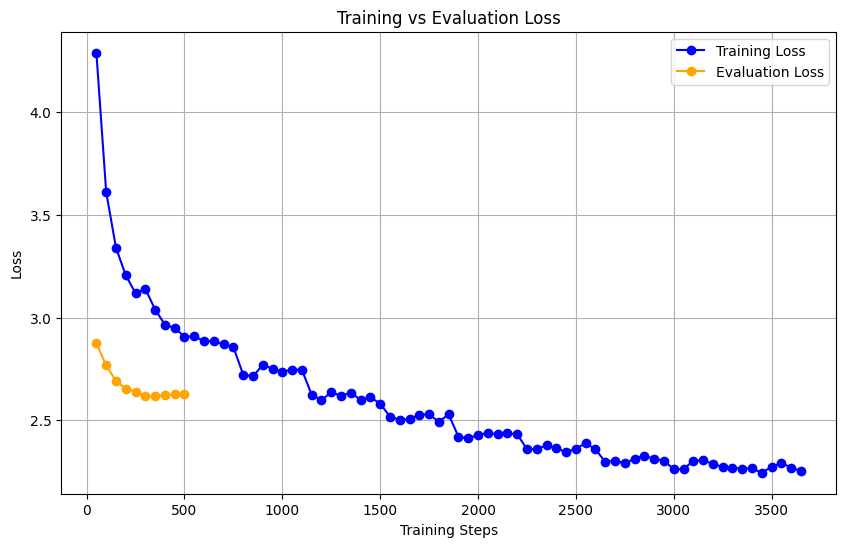

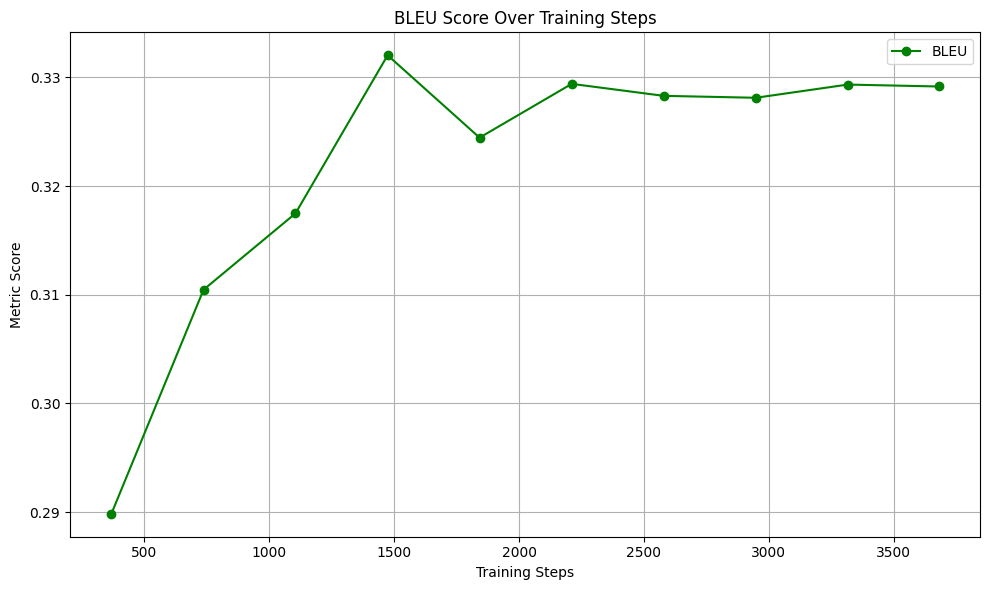

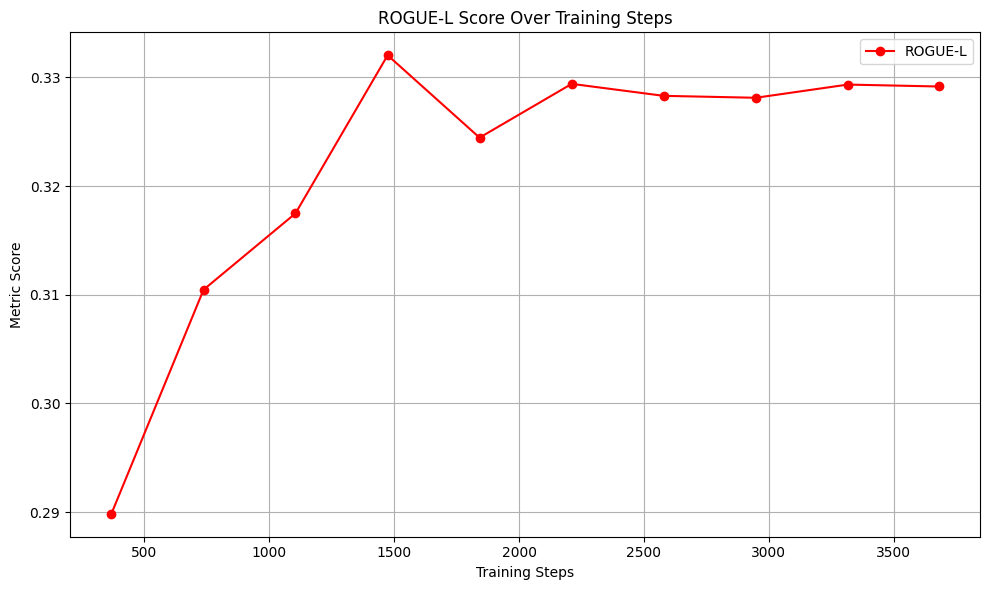

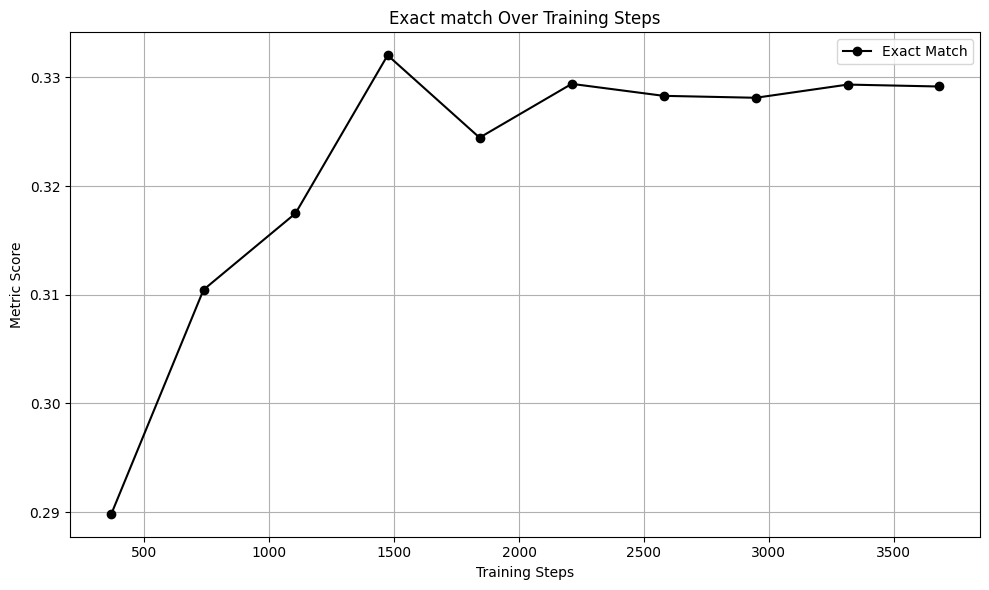

In [5]:
# Extract loss values from log history
train_loss = []
eval_loss = []
eval_bleu = []
eval_exact_match = []
eval_rogue = []
steps = []
eval_steps = []

for log in log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_BLEU" in log:
        eval_bleu.append(log["eval_BLEU"])
    if "eval_ROUGE-L" in log:
        eval_rogue.append(log["eval_ROUGE-L"])
    if "eval_exact_match" in log:
        eval_exact_match.append(log["eval_exact_match"])

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", color="blue", marker="o")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Evaluation Loss", color="orange", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot the BLEU
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="BLEU", marker="o", linestyle="-", color="green")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("BLEU Score Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the ROGUE
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="ROGUE-L", marker="o", linestyle="-", color="red")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("ROGUE-L Score Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the BLEU
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="Exact Match", marker="o", linestyle="-", color="black")
plt.xlabel("Training Steps")
plt.ylabel("Metric Score")
plt.title("Exact match Over Training Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing using Input

In [ ]:
# Load the trained T5 model and tokenizer
model_path = "/kaggle/working/t5_chatbot_model"
tokenizer_path = "/kaggle/working/t5_chatbot_tokenizer"

tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.eval() 

# Generate responses using Top-K and Top-P sampling
def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=64, top_k=50, top_p=0.95, temperature=1.0
):
    # Format the question for the model
    formatted_question = f"Answer the following question: {question}"
    
    # Tokenize the input
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128,
    )
    
    # Generate response with top-k and top-p sampling
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_length,
        do_sample=True,
        top_k=top_k,  
        top_p=top_p,  
        temperature=temperature,  
        pad_token_id=tokenizer.pad_token_id,
    )
    
    # Decode the generated response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return response

# Example usage
question = "What is diabetes ?"
response = generate_response_top_k_top_p(question, model, tokenizer)
print("Question:", question)
print("Response:", response)


Question: What is diabetes ?
Response: diabetes is a serious disease that causes blood glucose, or blood sugar, levels to be too high. it also damages the bodys ability to use glucose for energy. people who have diabetes have high blood glucose, or blood sugar, levels. blood glucose is a major cause of high blood sugar levels. having
